In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import sin, log10, cos, atan2, hypot
from FT_model import model_FT

def test_quality(wf, npixels=1024, radius=10):
    """
    Runs the FT and analysis on the wavefront
    Return the max of out outer region if the central peak brightness is less that the outer
    Else returns -1
    """
    FT = model_FT(wf, aperture*1e-3, npixels, [wl], fl, detector_pitch)
    central, outer = split_central(FT, npixels, radius)
    Q = get_Q(central, outer)
        
    return outer.max(), Q, FT

def display(wf, image, size=200, sizes=(12,6)):
    fig, axs = plt.subplots(1, 2, figsize=sizes)
    
    im = axs[0].imshow(np.abs(np.angle(wf)))
    plt.colorbar(im,ax=axs[0],fraction=0.046, pad=0.04)
    
    c = image.shape[0]/2
    im_out = image[int(c-size//2):int(c+size//2),int(c-size//2):int(c+size//2)]
    im = axs[1].imshow(im_out)
    plt.colorbar(im,ax=axs[1],fraction=0.046, pad=0.04)
    
    plt.show()
    
def split_central(image, npixels, radius):
    central = np.zeros([npixels, npixels], dtype = np.float)
    outer = np.zeros([npixels, npixels], dtype = np.float)
    c = npixels//2
    for i in range(npixels):
        for j in range(npixels):
            x = i - c
            y = j - c
            r = hypot(x,y)
            if r <= radius:
                central[i][j] = image[i][j]
            else:
                outer[i][j] = image[i][j]
    return central, outer 

def get_Q(central, outer, mod=False):
    """
    Gets the "quality factor" defined as the ratio of the peak brightnesses of the central and outer region.
    A value closer to zero indicates that the peak brightnesses is similar in both regions
    A value above zero indicated a higher peak power in the outer region, below zero indicates higher peak in central region
    mod returns the absolute value of Q, |Q|
    """
    max_central = central.max()
    max_outer = outer.max()
    if not mod:
        return max_outer/max_central - 1
    return np.abs(max_outer/max_central - 1)

In [103]:
def generate_spiral(gridsize, aperture, r_max, r_min, splits, settings):
    split = splits
    first = settings[0]
    second = settings[1]
    third = settings[2]
    fourth = settings[3]
    
    sampling = aperture/(gridsize//2)
    wfarr = np.zeros([gridsize, gridsize], dtype = np.complex128)
    c = gridsize//2
    for i in range(gridsize):
        for j in range(gridsize):
            x = i - c
            y = j - c
            phi = atan2(y, x)
            r = sampling*hypot(x,y)
            wfarr[i][j] = spiral(r, phi, aperture, r_max, r_min, split, first, second, third, fourth)
    return wfarr

def spiral(r, phi, aperture, r_max, r_min, split, first, second, third, fourth):
    # Spiral parameters
    alpha1 = 20.186
    m1 = 5
    eta1 = -1.308
    m2 = -5
    alpha2 = 16.149
    eta2 = -0.733
    m3 = 10
    alpha3 = 4.0372
    eta3 = -0.575    
    
    white = np.complex(1,0)
    black = -np.complex(1,0)
    v = np.complex(0,0)
    offset = np.complex(-(3**0.5)/2,1/2)

    if (r<=r_max and r>r_min):
        logr = log10(r)
        chi1 = alpha1*logr+m1*phi+eta1
        c1 = cos(chi1)
        chi2 = alpha2*logr+m2*phi+eta2
        c2 = cos(chi2)
        chi3 = alpha3*logr+m3*phi+eta3
        c3 = sin(chi3)
        
        z = 0 if (c1*c2*c3>0) else 1 
        for i in range(len(split)):
            if (r <= split[i] and r > split[i+1]): # Finds which region we are in
                
                if i%2 != 0:
                    z = np.abs(z-1)
                
                # First quadrant
                if c3 < 0 and sin(chi3/2.) <= 0:
                    return black if first[i][z] else white

                # Second qudrant
                elif c3 >= 0 and sin(chi3/2.) <= 0:
                    return black if second[i][np.abs(z-1)] else white
#                     return black if second[i][z] else white
                
                # Third quadrant
                elif c3 < 0 and sin(chi3/2.) > 0:
                    return black if third[i][z] else white
        
                # Fourth qudrant
                else: 
                    return black if fourth[i][np.abs(z-1)] else white
#                     return black if fourth[i][z] else white
                    
    elif r < r_min:
#         v = black
        v = np.complex(0,0)
    return v

In [190]:
aperture = 0.015                 # Aperture (m)
gridsize = 1024                  # Gridsize of the wavefront array
npixels = 1024                   # Size of detector, in pixels
wl = 0.525e-9                    # Wavelength values (micrometers)
fl = 0.15                        # Focal length (m)
detector_pitch = 1.12e-6         # m/pixel on detector (pixel spacing)

split_values = [15.15, 12.4, 10.17, 8.33, 6.83, 5.6, 3.75, 3.05, 2.5, 2.07, 1.7, 1.4, 1.14, 0.925, 0.76, 0.62]
r_max = split_values[0]
r_min = split_values[-11]

# first = [[1,0],[1,0],[0,1],[1,0],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0]]
# second = [[0,1],[0,1],[1,0],[0,1],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1]]
# third = [[1,0],[1,0],[0,1],[1,0],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0]]
# fourth = [[0,1],[0,1],[1,0],[0,1],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1],[1,0],[0,1]]

first  = [[1,1],[1,1],[1,0],[0,1],[1,0]]
second = [[0,1],[1,0],[0,1],[1,0],[0,1]]
third  = [[1,0],[0,1],[1,0],[0,1],[1,0]]
fourth = [[0,1],[1,0],[0,1],[1,0],[0,1]]

splits = split_values
settings = (first, second, third, fourth)

Q: -0.50604
H: 63.87760


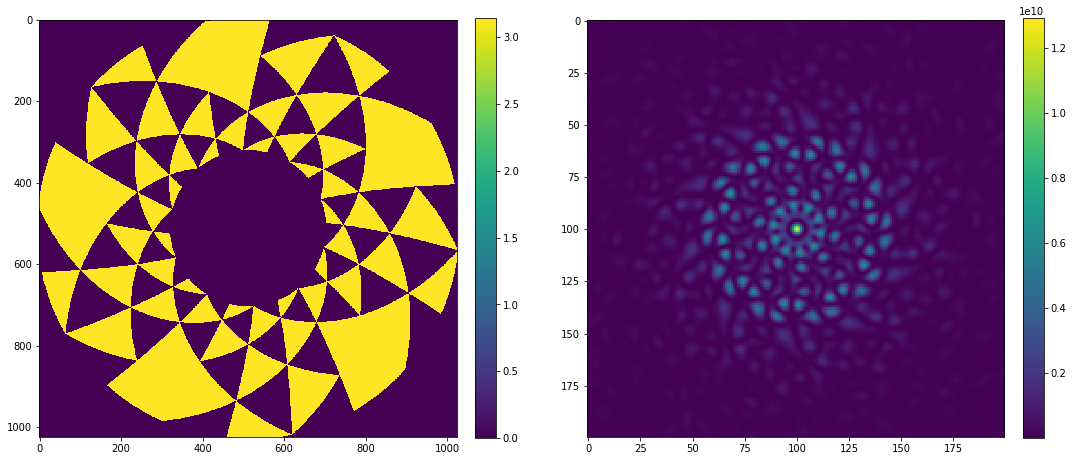

CPU times: user 7.26 s, sys: 546 ms, total: 7.81 s
Wall time: 6.87 s


In [191]:
%%time
wf = generate_spiral(gridsize, aperture*1e3, r_max, r_min, splits, settings)
val, Q, FT = test_quality(wf)

print("Q: {:.5f}".format(Q))
print("H: {:.5f}".format(val*1e-8))
display(wf, FT, sizes=(18,18))

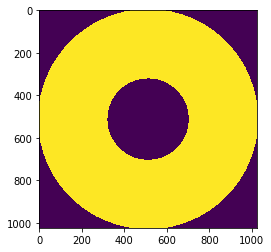

In [189]:
plt.imshow(np.abs(wf))

Q: 61.37208
H: 81.23604


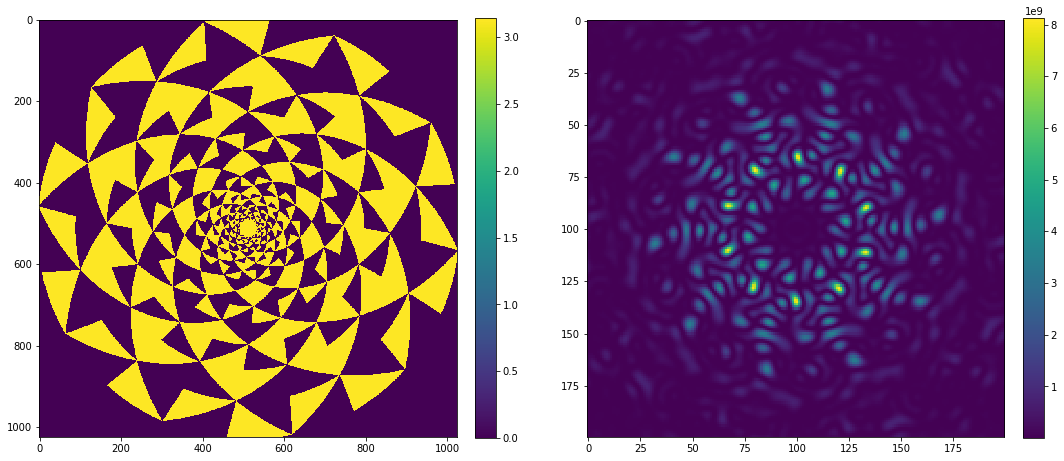

In [85]:
first = [[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1]]
second = [[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0]]
third = [[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1]]
fourth = [[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0]]

splits = split_values
settings = (first, second, third, fourth)

wf = generate_spiral(gridsize, aperture*1e3, r_max, r_min, splits, settings)
val, Q, FT = test_quality(wf)

print("Q: {:.5f}".format(Q))
print("H: {:.5f}".format(val*1e-8))
display(wf, FT, sizes=(18,18))

Q: 0.26697
H: 57.47538


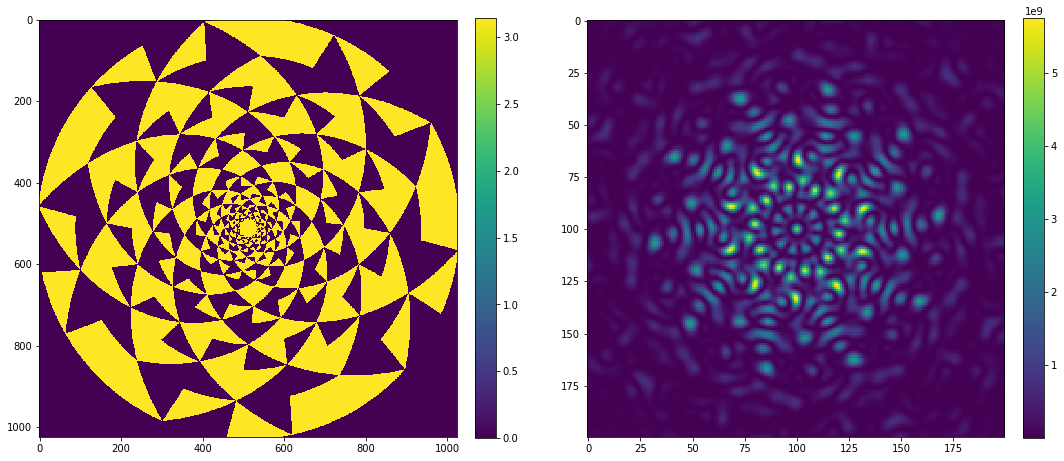

In [86]:
first = [[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1]]
second = [[1,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0]]
third = [[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1]]
fourth = [[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0]]

splits = split_values
settings = (first, second, third, fourth)

wf = generate_spiral(gridsize, aperture*1e3, r_max, r_min, splits, settings)
val, Q, FT = test_quality(wf)

print("Q: {:.5f}".format(Q))
print("H: {:.5f}".format(val*1e-8))
display(wf, FT, sizes=(18,18))

Q: 1.13506
H: 74.79845


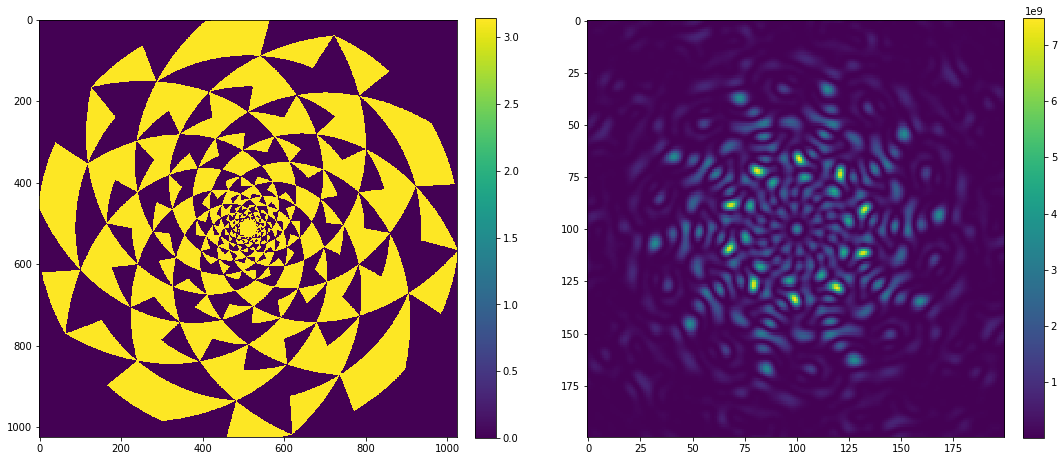

In [88]:
first = [[1,1],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1]]
second = [[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0]]
third = [[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1]]
fourth = [[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0],[1,0],[0,1],[0,1],[1,0]]

splits = split_values
settings = (first, second, third, fourth)

wf = generate_spiral(gridsize, aperture*1e3, r_max, r_min, splits, settings)
val, Q, FT = test_quality(wf)

print("Q: {:.5f}".format(Q))
print("H: {:.5f}".format(val*1e-8))
display(wf, FT, sizes=(18,18))